In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
import itertools
#import NAFFlib

In [2]:
# As a useful exercise to put in practice what we learned so far, we will now
# track particles, obtain the tunes and plot the footprint of the particles
# Let's setup the collider as always
collider = xt.Multiline.from_json('../data/collider_thin.json')
collider.build_trackers()
with open('../data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
twiss_b1 = collider['lhcb1'].twiss()
ctx = xo.ContextCpu()
# First of all we change the octupole strength
collider.vars['i_oct_b1'] = 250

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
# Now we define the amplitudes and the angles of the particles
twiss_b1 = collider['lhcb1'].twiss()
r_min = 1.1
r_max = 6
radial_list = np.linspace(r_min, r_max, 40, endpoint=False)
n_angles = 5
theta_list = np.linspace(10, 80, n_angles+10)[1:-1]
particle_list = [(particle_id, ii[0], ii[1]) for particle_id, ii in
                 enumerate(itertools.product(radial_list, theta_list))]
particle_list = list(np.array_split(particle_list, 1))
for ii, my_list in enumerate(particle_list):
    print(ii, my_list)
    my_parts = pd.DataFrame(my_list,
                columns=['particle_id','normalized amplitude in xy-plane',
                         'angle in xy-plane [deg]'])
length = len(my_parts['angle in xy-plane [deg]'])
r  = my_parts['normalized amplitude in xy-plane']
theta = my_parts['angle in xy-plane [deg]']*np.pi/180
# We build the normalized coordinates
x_in_sigmas = r*np.cos(theta)
px_in_sigmas = 0
y_in_sigmas = r*np.sin(theta)
py_in_sigmas = 0
zeta = 0
delta = 0
# We convert the coordinates to numpy arrays
x_in_sigmas = np.array(x_in_sigmas)
y_in_sigmas = np.array(y_in_sigmas)
# We define the emittances
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6

0 [[  0.       1.1     15.    ]
 [  1.       1.1     20.    ]
 [  2.       1.1     25.    ]
 ...
 [517.       5.8775  65.    ]
 [518.       5.8775  70.    ]
 [519.       5.8775  75.    ]]


In [4]:
line = collider['lhcb1']
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)    
particles = xp.build_particles(
    line=line,
    particle_ref=particle_ref,
    zeta=zeta, delta=delta,
    x_norm=x_in_sigmas, px_norm=px_in_sigmas,
    y_norm=y_in_sigmas, py_norm=py_in_sigmas,
    nemitt_x=normal_emitt_x, nemitt_y = normal_emitt_y)

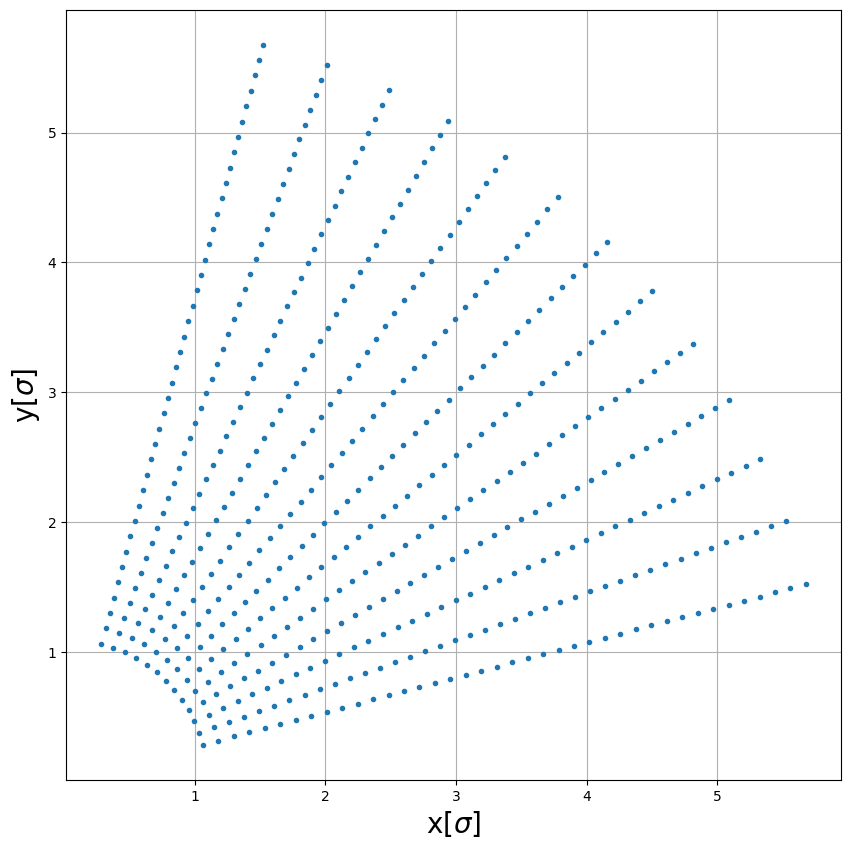

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(x_in_sigmas,y_in_sigmas,'.')
plt.xlabel(r'x[$\sigma$]', size = 20)
plt.ylabel(r'y[$\sigma$]', size = 20)
plt.grid()

In [6]:
# This time we need to save all the values of the coordinates at each turn
# so that we can extract the tunes
n_turns = 1024
collider['lhcb1'].track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True)

In [7]:
# We retrieve the turn by turn data
print('We tracked ',np.shape(collider['lhcb1'].record_last_track.x)[0], 
      'particles, for ', np.shape(collider['lhcb1'].record_last_track.x)[1], 'turns')
x = collider['lhcb1'].record_last_track.x
y = collider['lhcb1'].record_last_track.y
# We can print the values of the coordinates for the first particle
print('The x coordinate of the first particle is ', x[0,:])
# We can now compute the tunes with the NAFF algorithm
# qx_i = []
# qy_i = []
# for ii in range(len(x)):
#     qx_i.append(NAFFlib.get_tune(x[ii,:]))
#     qy_i.append(NAFFlib.get_tune(y[ii,:]))
# qx_i = np.array(qx_i)
# qy_i = np.array(qy_i)
# # plot the tunes
# fig, ax = plt.subplots(figsize=(5, 5))
# plt.plot(qx_i, qy_i, '.')
# #plot a star at twiss_b1["mux"][-1] and twiss_b1["muy"][-1]
# plt.plot(twiss_b1["mux"][-1]%1, twiss_b1["muy"][-1]%1, '*', markersize = 10, label = 'Machine Tune')
# plt.xlabel(r'$q_x$', size = 10)
# plt.ylabel(r'$q_y$', size = 10)
# plt.legend(fontsize = 10)
# plt.title('Footprint', size = 10)
# plt.grid()
#Now repeat the exercise for an octupolar current of -250 A!

We tracked  520 particles, for  1024 turns
The x coordinate of the first particle is  [ 2.14451828e-04 -7.91307099e-05 -1.56006849e-04 ... -1.75708357e-04
  1.78625617e-04  4.38472014e-05]
